In [2]:
import os
from datetime import datetime, date
import calendar
import time
import json
import numpy as np
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor


from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

from catboost import CatBoostRegressor, CatBoostClassifier, Pool, metrics, cv

from sklearn.metrics import recall_score, r2_score

%matplotlib inline

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [3]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [4]:
# df = pd.read_csv("data/train_dataset_train.csv", nrows = 10000)
df_train = pd.read_csv("data/train_dataset_train.csv")
# df_add = pd.read_csv("subway.csv")
df_test = pd.read_csv("data/test_dataset_test.csv")

In [7]:
df_train.head()

,id,ticket_id,ticket_type_nm,entrance_id,entrance_nm,station_id,station_nm,line_id,line_nm,pass_dttm,time_to_under,label
0,1,40BD89EC85646EFB69E283F39C298E60,Пропуск FacePay,2402,Лефортово БКЛ,11007,Лефортово,11,Большая кольцевая,2022-09-12 05:00:13,216.316667,8001
1,2,126727A96489CC976A8C08E5CEB00542,СК учащегося 30 дней,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:54,648.183333,9011
2,3,D28CE6A9E0E5B6D213470A97CFF32485,БСК дружинника г.Москвы,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:55,865.333333,7022
3,4,015DA44B523C062B5BFEFF3FB0E64B9E,30 дней,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:01:13,1048.233333,2022
4,5,95B19C6F3A504727AC3EA56EB7E3E80F,КОШЕЛЕК,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:02:55,965.600000,2017


In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1091021 entries, 0 to 1091020
Data columns (total 12 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   id              1091021 non-null  int64  
 1   ticket_id       1091021 non-null  object 
 2   ticket_type_nm  1091021 non-null  object 
 3   entrance_id     1091021 non-null  int64  
 4   entrance_nm     1091021 non-null  object 
 5   station_id      1091021 non-null  int64  
 6   station_nm      1091021 non-null  object 
 7   line_id         1091021 non-null  int64  
 8   line_nm         1091021 non-null  object 
 9   pass_dttm       1091021 non-null  object 
 10  time_to_under   1091021 non-null  float64
 11  label           1091021 non-null  int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 99.9+ MB


In [10]:
df_test.ticket_type_nm.value_counts()

КОШЕЛЕК                                                   134786
30 дней ЕДИНЫЙ ТК                                          90977
Социальная карта москвича                                  65307
30 дней                                                    60807
90 дней ЕДИНЫЙ ТК                                          29938
30 дней СК студента                                        24952
60 поездок ЕДИНЫЙ ТК                                       23828
30 дней Пригород ТК                                        22854
СК студента 30 дней                                        20363
ББК                                                        15183
30 дней СК учащегося                                       12493
365 дней ЕДИНЫЙ ТК                                         11215
СК учащегося 30 дней                                        9099
Социальная карта жителя Моск. области                       7880
90 дней                                                     6519
Пропуск FacePay          

In [11]:
df_train.ticket_type_nm.value_counts()

КОШЕЛЕК                                                   262499
30 дней ЕДИНЫЙ ТК                                         177041
Социальная карта москвича                                 127022
30 дней                                                   117064
90 дней ЕДИНЫЙ ТК                                          58071
30 дней СК студента                                        48658
60 поездок ЕДИНЫЙ ТК                                       46542
30 дней Пригород ТК                                        45381
СК студента 30 дней                                        39395
ББК                                                        29674
30 дней СК учащегося                                       24307
365 дней ЕДИНЫЙ ТК                                         20859
СК учащегося 30 дней                                       16933
Социальная карта жителя Моск. области                      15551
90 дней                                                    12817
Пропуск FacePay          

<AxesSubplot: >

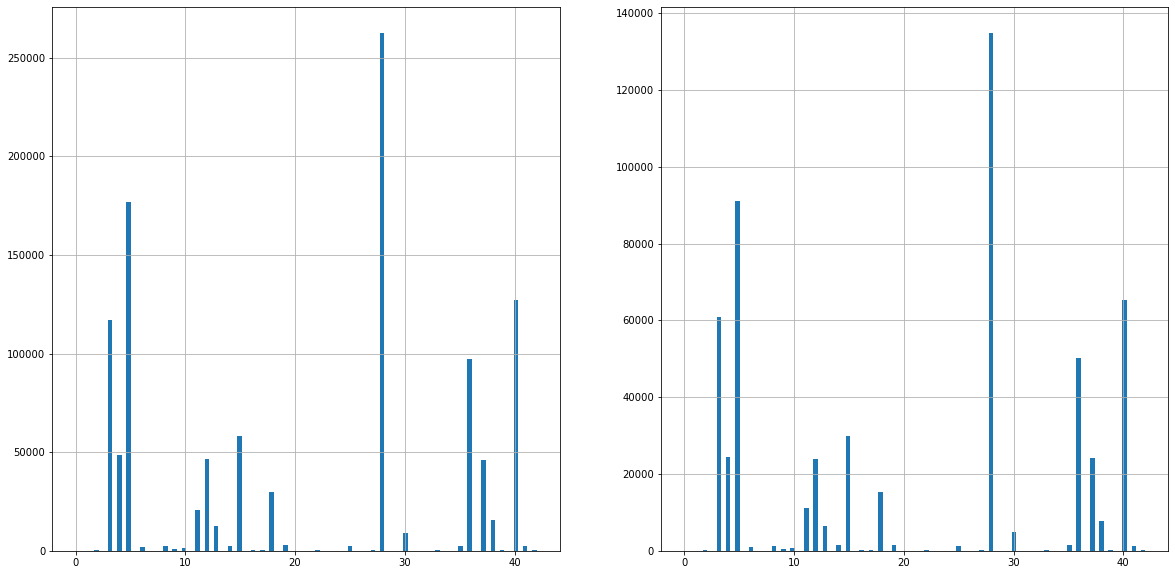

In [93]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

df_train.ticket_type_nm.hist(bins=100, ax=ax[0])
df_test.ticket_type_nm.hist(bins=100, ax=ax[1])

<AxesSubplot: xlabel='label', ylabel='Density'>

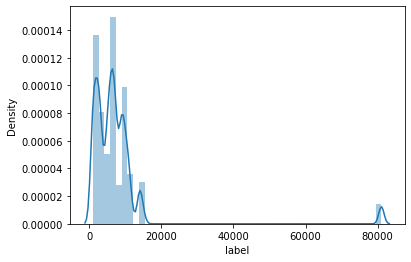

In [46]:
sns.distplot(df_train['label'])

In [64]:
df1 = df_train.ticket_type_nm.unique()
# df1.tolist()

In [65]:
df2 = df_test.ticket_type_nm.unique()
# df2.tolist()

In [66]:
for i in df1.tolist():
    if i not in df2.tolist():
        print(i)

In [67]:
for i in df2.tolist():
    if i not in df1.tolist():
        print(i)

In [63]:
df_train = df_train[df_train.ticket_type_nm != 'ВЕСБ МО с сопровождающим']
df_train = df_train[df_train.ticket_type_nm != 'ВЕСБ МО (тип 6)']

In [68]:
df_ste = df_test.station_id.unique()
# df_ste.tolist()

In [69]:
df_str = df_train.station_id.unique()
# df_str.tolist()

In [70]:
for i in df_str.tolist():
    if i not in df_ste.tolist():
        print(i)

In [71]:
for i in df_ste.tolist():
    if i not in df_str.tolist():
        print(i)

In [72]:
df_train[df_train.station_id == 13006]

,id,ticket_id,ticket_type_nm,entrance_id,entrance_nm,station_id,station_nm,line_id,line_nm,pass_dttm,time_to_under,label


In [73]:
df_test[df_test.station_id == 13006]

,id,ticket_id,ticket_type_nm,entrance_id,entrance_nm,station_id,station_nm,line_id,line_nm,pass_dttm


In [74]:
df_train = df_train[df_train.station_id != 13006]

In [75]:
df_train[df_train.station_id == 13006]

,id,ticket_id,ticket_type_nm,entrance_id,entrance_nm,station_id,station_nm,line_id,line_nm,pass_dttm,time_to_under,label


In [26]:
df_train.loc[df_train.ticket_type_nm.str.contains('учащегося', case=True), 'ticket_type_nm'] = 'СК учащегося'
df_test.loc[df_test.ticket_type_nm.str.contains('учащегося', case=True), 'ticket_type_nm'] = 'СК учащегося'

In [27]:
df_train.loc[df_train.ticket_type_nm.str.contains('студента', case=True), 'ticket_type_nm'] = 'СК студента'
df_test.loc[df_test.ticket_type_nm.str.contains('студента', case=True), 'ticket_type_nm'] = 'СК студента'

In [28]:
df_train[df_train.ticket_type_nm.str.contains('учащегося', case=True)].ticket_type_nm.value_counts()

СК учащегося    45958
Name: ticket_type_nm, dtype: int64

In [29]:
df_test[df_test.ticket_type_nm.str.contains('учащегося', case=True)].ticket_type_nm.value_counts()

СК учащегося    24076
Name: ticket_type_nm, dtype: int64

In [30]:
df_train[df_train.ticket_type_nm.str.contains('студента', case=True)].ticket_type_nm.value_counts()

СК студента    97332
Name: ticket_type_nm, dtype: int64

In [31]:
df_test[df_test.ticket_type_nm.str.contains('студента', case=True)].ticket_type_nm.value_counts()

СК студента    50112
Name: ticket_type_nm, dtype: int64

In [32]:
dict_ = {
#     'СК учащегося 30 дней': '30 дней СК учащегося',
#     'СК учащегося 90 дней': '90 дней СК учащегося',    
#     'СК студента на 3 месяца': '90 дней СК студента',
#     'СК студента 30 дней': '30 дней СК студента',
#     'СК студента 90 дней': '90 дней СК студента',
    'СК аспиранта 30 дней': '30 дней СК аспиранта',
    'СК аспиранта 90 дней': '90 дней СК аспиранта',
    'СК ординатора 30 дней': '30 дней СК ординатора',
    'СК ординатора 90 дней': '90 дней СК ординатора',
    '30 дней Пригород ТК': '30 дней  Пригород',
    '90 дней Пригород ТК': '90 дней  Пригород',   
    '365 дней Пригород ТК': '365 дней  Пригород',
    'Билет 1 сутки ЕДИНЫЙ': '1 сутки ЕДИНЫЙ ТК',
    'СК ассистента-стажера 30 дней': '30 дней СК ассистента-стажера',
}


for i in dict_:
    print(i, dict_[i])
    df_train.loc[df_train['ticket_type_nm']==i, 'ticket_type_nm'] = dict_[i]
    df_test.loc[df_test['ticket_type_nm']==i, 'ticket_type_nm'] = dict_[i]
    

СК аспиранта 30 дней 30 дней СК аспиранта
СК аспиранта 90 дней 90 дней СК аспиранта
СК ординатора 30 дней 30 дней СК ординатора
СК ординатора 90 дней 90 дней СК ординатора
30 дней Пригород ТК 30 дней  Пригород
90 дней Пригород ТК 90 дней  Пригород
365 дней Пригород ТК 365 дней  Пригород
Билет 1 сутки ЕДИНЫЙ 1 сутки ЕДИНЫЙ ТК
СК ассистента-стажера 30 дней 30 дней СК ассистента-стажера


In [33]:
crt = 'ассистента'
df_test[df_test.ticket_type_nm.str.contains(crt, case=True)].ticket_type_nm.value_counts()

30 дней СК ассистента-стажера    37
СК ассистента-стажера 90 дней     8
Name: ticket_type_nm, dtype: int64

In [34]:
df_train[df_train.ticket_type_nm.str.contains(crt, case=True)].ticket_type_nm.value_counts()

30 дней СК ассистента-стажера    83
СК ассистента-стажера 90 дней    10
Name: ticket_type_nm, dtype: int64

In [35]:
crt = 'аспиранта'
df_test[df_test.ticket_type_nm.str.contains(crt, case=True)].ticket_type_nm.value_counts()

30 дней СК аспиранта    966
90 дней СК аспиранта    336
Name: ticket_type_nm, dtype: int64

In [36]:
df_train[df_train.ticket_type_nm.str.contains(crt, case=True)].ticket_type_nm.value_counts()

30 дней СК аспиранта    1914
90 дней СК аспиранта     602
Name: ticket_type_nm, dtype: int64

In [37]:
crt = 'ординатора'
df_test[df_test.ticket_type_nm.str.contains(crt, case=True)].ticket_type_nm.value_counts()

30 дней СК ординатора    1200
90 дней СК ординатора     223
Name: ticket_type_nm, dtype: int64

In [38]:
df_train[df_train.ticket_type_nm.str.contains(crt, case=True)].ticket_type_nm.value_counts()

30 дней СК ординатора    2430
90 дней СК ординатора     503
Name: ticket_type_nm, dtype: int64

In [76]:
df_train.ticket_type_nm.value_counts()

28    262497
5     177041
40    127016
3     117064
36     97332
15     58071
4      48479
12     46541
37     45958
18     29674
11     20859
38     15551
13     12817
30      9234
19      2829
35      2634
25      2555
14      2446
8       2430
41      2272
6       1914
10      1203
9        768
16       602
33       541
2        504
17       503
22       335
39       244
42       233
27       159
0        125
21       113
32       112
7         83
23        61
20        60
24        56
29        44
31        24
34        10
1          7
26         6
Name: ticket_type_nm, dtype: int64

In [40]:
len(df_train.ticket_type_nm.unique().tolist())

43

In [41]:
len(df_test.ticket_type_nm.unique().tolist())

43

In [42]:
df_train["ticket_type_nm"] = pd.Categorical(df_train["ticket_type_nm"])
df_train["ticket_type_nm"].astype('category').cat.codes
df_train["ticket_type_nm"] = df_train["ticket_type_nm"].cat.codes

df_test["ticket_type_nm"] = pd.Categorical(df_test["ticket_type_nm"])
df_test["ticket_type_nm"].astype('category').cat.codes
df_test["ticket_type_nm"] = df_test["ticket_type_nm"].cat.codes

In [43]:
df_train.loc[(df_train['station_nm']=='Авиамоторная') & (df_train['line_id']==11), 'line_id'] = 15
df_train.loc[(df_train['station_nm']=='Авиамоторная') & (df_train['line_id']==15), 'line_nm'] = 'Некрасовская'

df_train.loc[(df_train['station_nm']=='Лефортово') & (df_train['line_id']==11), 'line_id'] = 15
df_train.loc[(df_train['station_nm']=='Лефортово') & (df_train['line_id']==15), 'line_nm'] = 'Некрасовская'

df_train.loc[(df_train['station_nm']=='Электрозаводская') & (df_train['line_id']==11), 'line_id'] = 15
df_train.loc[(df_train['station_nm']=='Электрозаводская') & (df_train['line_id']==15), 'line_nm'] = 'Некрасовская'


df_test.loc[(df_test['station_nm']=='Авиамоторная') & (df_test['line_id']==11), 'line_id'] = 15
df_test.loc[(df_test['station_nm']=='Авиамоторная') & (df_test['line_id']==15), 'line_nm'] = 'Некрасовская'

df_test.loc[(df_test['station_nm']=='Лефортово') & (df_test['line_id']==11), 'line_id'] = 15
df_test.loc[(df_test['station_nm']=='Лефортово') & (df_test['line_id']==15), 'line_nm'] = 'Некрасовская'

df_test.loc[(df_test['station_nm']=='Электрозаводская') & (df_test['line_id']==11), 'line_id'] = 15
df_test.loc[(df_test['station_nm']=='Электрозаводская') & (df_test['line_id']==15), 'line_nm'] = 'Некрасовская'

In [44]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561890 entries, 0 to 561889
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   id              561890 non-null  int64 
 1   ticket_id       561890 non-null  object
 2   ticket_type_nm  561890 non-null  int8  
 3   entrance_id     561890 non-null  int64 
 4   entrance_nm     561890 non-null  object
 5   station_id      561890 non-null  int64 
 6   station_nm      561890 non-null  object
 7   line_id         561890 non-null  int64 
 8   line_nm         561890 non-null  object
 9   pass_dttm       561890 non-null  object
dtypes: int64(4), int8(1), object(5)
memory usage: 39.1+ MB


In [45]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1091007 entries, 0 to 1091020
Data columns (total 12 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   id              1091007 non-null  int64  
 1   ticket_id       1091007 non-null  object 
 2   ticket_type_nm  1091007 non-null  int8   
 3   entrance_id     1091007 non-null  int64  
 4   entrance_nm     1091007 non-null  object 
 5   station_id      1091007 non-null  int64  
 6   station_nm      1091007 non-null  object 
 7   line_id         1091007 non-null  int64  
 8   line_nm         1091007 non-null  object 
 9   pass_dttm       1091007 non-null  object 
 10  time_to_under   1091007 non-null  float64
 11  label           1091007 non-null  int64  
dtypes: float64(1), int64(5), int8(1), object(5)
memory usage: 100.9+ MB


С помощью кода из файла "dadata_metro.py" формируем датасет содержащий имя станции ее координаты и удаленность от центра

In [54]:
stations = df_train.station_nm.unique().tolist()
stations

['Лефортово',
 'Войковская',
 'Аэропорт',
 'Косино',
 'Котельники',
 'Сокол',
 'Новогиреево',
 'Кунцевская',
 'Проспект Вернадского',
 'Динамо',
 'Черкизовская',
 'Отрадное',
 'Крылатское',
 'Мнёвники',
 'Хорошёвская',
 'Селигерская',
 'Павелецкая',
 'Первомайская',
 'Орехово',
 'Тургеневская',
 'Выставочная',
 'Кропоткинская',
 'Площадь Ильича',
 'Мякинино',
 'Лухмановская',
 'Свиблово',
 'Бутырская',
 'Петровско-Разумовская',
 'Владыкино',
 'Комсомольская',
 'Таганская',
 'Проспект Мира',
 'Шипиловская',
 'Третьяковская',
 'Выхино',
 'Каширская',
 'Савёловская',
 'Семёновская',
 'Рязанский проспект',
 'Чертановская',
 'Печатники',
 'Балтийская',
 'Преображенская площадь',
 'Севастопольская',
 'Тимирязевская',
 'Перово',
 'Панфиловская',
 'Борисово',
 'ВДНХ',
 'Новые Черёмушки',
 'Партизанская',
 'Ботанический сад',
 'Лубянка',
 'Спартак',
 'Солнцево',
 'Аннино',
 'Нижегородская',
 'Бульвар Рокоссовского',
 'Смоленская',
 'Новокосино',
 'Локомотив',
 'Белорусская',
 'Планерная',
 'Рас

In [ ]:
from dadata import Dadata
import csv
from geopy.distance import geodesic

token = "e7a069e82e59b21e36a44924ebfceeb16fc50923"
secret = "b892f8e65a04c3d363be0db08aa6939fdf37b8aa"

zero_point = (55.75222, 37.61556)

data_st = {}

with Dadata(token, secret) as dadata:
    with open('data/stations.csv', 'w', newline='', encoding='utf-8') as csvfile:
        staitionwriter = csv.writer(csvfile,
                                    delimiter=',',
                                    quotechar='|',
                                    quoting=csv.QUOTE_MINIMAL)
        staitionwriter.writerow(['station_nm', 'line_id', 'geo_lat', 'geo_lon', 'st_dist_from_center'])

        for station in stations:
            
            result = dadata.suggest("metro", station)
            for i in result:

                st_nm = station
                st_line_id = i['data']['line_id']
                if st_line_id=='8А':
                    st_line_id = 81
                elif st_line_id == 'М':
                    st_line_id = 13
                st_line_nm = i['data']['line_name']
                st_geo_lat = i['data']['geo_lat']
                st_geo_lon = i['data']['geo_lon']
                st_dist_from_center = geodesic(zero_point, (st_geo_lat, st_geo_lon)).km

#                 print(st_nm,
#                       st_line_id,
#                       st_line_nm,
#                       st_geo_lat,
#                       st_geo_lon,
#                       st_dist_from_center,
#                       )
    
                staitionwriter.writerow([st_nm,
                                         st_line_id,
                                         st_geo_lat,
                                         st_geo_lon,
                                         st_dist_from_center])

In [201]:
df_stations = pd.read_csv("data/stations.csv")

In [ ]:
df_stations = df_stations[df_stations.line_id!='D1']

In [ ]:
df_stations = df_stations[df_stations.line_id!='D2']

In [ ]:
df_stations.line_id = df_stations.line_id.astype('int')

In [ ]:
df_stations.to_csv("data/stations2.csv", index=False)

In [77]:
def get_lat(x):
    import pandas as pd
    df_stations = pd.read_csv("data/stations2.csv")
    
    try:
        station_ = x['station_nm']
        line_id_ = x['line_id']
        res = df_stations[(df_stations['station_nm']==station_) & (df_stations['line_id']==line_id_)]['geo_lat'].to_list()[0]
#         print(res)
        return float(res)
    except:
        print('NaN', station_, line_id_)
        return 'NaN'
    
def get_lon(x):
    import pandas as pd
    df_stations = pd.read_csv("data/stations2.csv")
    try:
        station_ = x['station_nm']
        line_id_ = x['line_id']
        res = df_stations[(df_stations['station_nm']==station_) & (df_stations['line_id']==line_id_)]['geo_lon'].to_list()[0]
#         print(res)
        return float(res)
    except:
        print('NaN', station_, line_id_)
        return 'NaN'
    
def get_dist(x):
    import pandas as pd
    df_stations = pd.read_csv("data/stations2.csv")
    try:
        station_ = x['station_nm']
        line_id_ = x['line_id']
        res = df_stations[(df_stations['station_nm']==station_) & (df_stations['line_id']==line_id_)]['st_dist_from_center'].to_list()[0]
#         print(res)
        return float(res)
    except:
        print('NaN', station_, line_id_)
        return 'NaN'

In [78]:
df_train['geo_lat'] = df_train.parallel_apply(get_lat, axis=1)
df_test['geo_lat'] = df_test.parallel_apply(get_lat, axis=1)

In [79]:
df_train['geo_lon'] = df_train.parallel_apply(get_lon, axis=1)
df_test['geo_lon'] = df_test.parallel_apply(get_lon, axis=1)

In [80]:
df_train['geo_dist'] = df_train.parallel_apply(get_dist, axis=1)
df_test['geo_dist'] = df_test.parallel_apply(get_dist, axis=1)

In [81]:
# df_train['start_point'] = df_train['station_id'].astype('str')+'-'+df_train['line_id'].astype('str')
# df_test['start_point'] = df_test['station_id'].astype('str')+'-'+df_test['line_id'].astype('str')

In [94]:
df_test.head()

,id,ticket_id,ticket_type_nm,entrance_id,entrance_nm,station_id,station_nm,line_id,line_nm,pass_dttm,geo_lat,geo_lon,geo_dist,day,hours,day_of_week,isDayOff
0,1091022,425A13E16226CA01032043111488E0F5,28,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:03,55.818923,37.497791,10.475917,12,5,Monday,0
1,1091023,F94EDC107A4E054786882F9453C1B93F,30,184,Молодёжная (Западный),3010,Молодёжная,3,Арбатско-Покровская,2022-09-12 05:00:45,55.741375,37.415627,12.613728,12,5,Monday,0
2,1091024,8F13BFBA98A7DD34B11BD2DDCC5CA68E,36,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:52,55.818923,37.497791,10.475917,12,5,Monday,0
3,1091025,7B98691636EC418ABF6FEDDE4D7C68FC,28,107,Сокол ( Южн./Вост. ),2018,Сокол,2,Замоскворецкая,2022-09-12 05:00:58,55.805564,37.515245,8.654266,12,5,Monday,0
4,1091026,679C55C28CB36FB546FD104502C0B3DB,28,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:01:39,55.818923,37.497791,10.475917,12,5,Monday,0


In [83]:
# df_train["start_point"] = pd.Categorical(df_train["start_point"])
# df_train["start_point"].astype('category').cat.codes
# df_train["start_point"] = df_train["start_point"].cat.codes

# df_test["start_point"] = pd.Categorical(df_test["start_point"])
# df_test["start_point"].astype('category').cat.codes
# df_test["start_point"] = df_test["start_point"].cat.codes

In [84]:
df_train["day"] = df_train.pass_dttm.parallel_map(lambda x: int(x.split("-")[2].split(" ")[0]))
df_train["hours"] = df_train.pass_dttm.parallel_map(lambda x: int(x.split("-")[2].split(" ")[1].split(":")[0]))

df_test["day"] = df_test.pass_dttm.parallel_map(lambda x: int(x.split("-")[2].split(" ")[0]))
df_test["hours"] = df_test.pass_dttm.parallel_map(lambda x: int(x.split("-")[2].split(" ")[1].split(":")[0]))

In [85]:
# df_train["day_of_week"] = df_train.pass_dttm.map(lambda x: calendar.day_name[datetime.strptime(x, '%Y-%m-%d %H:%M:%S').weekday()])

In [86]:
# df_test["day_of_week"] = df_test.pass_dttm.map(lambda x: calendar.day_name[datetime.strptime(x, '%Y-%m-%d %H:%M:%S').weekday()])

In [87]:
df_train["isDayOff"] = df_train.day_of_week.parallel_map(lambda x: 1 if x=='Saturday' or x=='Sunday' else 0)
df_test["isDayOff"] = df_test.day_of_week.parallel_map(lambda x: 1 if x=='Saturday' or x=='Sunday' else 0)

In [169]:
# df_train["day_of_week"] = pd.Categorical(df_train["day_of_week"])
# df_train["day_of_week"].astype('category').cat.codes
# df_train["day_of_week"] = df_train["day_of_week"].cat.codes

# df_test["day_of_week"] = pd.Categorical(df_test["day_of_week"])
# df_test["day_of_week"].astype('category').cat.codes
# df_test["day_of_week"] = df_test["day_of_week"].cat.codes

In [95]:
df_test.head()

,id,ticket_id,ticket_type_nm,entrance_id,entrance_nm,station_id,station_nm,line_id,line_nm,pass_dttm,geo_lat,geo_lon,geo_dist,day,hours,day_of_week,isDayOff
0,1091022,425A13E16226CA01032043111488E0F5,28,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:03,55.818923,37.497791,10.475917,12,5,Monday,0
1,1091023,F94EDC107A4E054786882F9453C1B93F,30,184,Молодёжная (Западный),3010,Молодёжная,3,Арбатско-Покровская,2022-09-12 05:00:45,55.741375,37.415627,12.613728,12,5,Monday,0
2,1091024,8F13BFBA98A7DD34B11BD2DDCC5CA68E,36,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:52,55.818923,37.497791,10.475917,12,5,Monday,0
3,1091025,7B98691636EC418ABF6FEDDE4D7C68FC,28,107,Сокол ( Южн./Вост. ),2018,Сокол,2,Замоскворецкая,2022-09-12 05:00:58,55.805564,37.515245,8.654266,12,5,Monday,0
4,1091026,679C55C28CB36FB546FD104502C0B3DB,28,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:01:39,55.818923,37.497791,10.475917,12,5,Monday,0


In [96]:
df_train.head()

,id,ticket_id,ticket_type_nm,entrance_id,entrance_nm,station_id,station_nm,line_id,line_nm,pass_dttm,time_to_under,label,geo_lat,geo_lon,geo_dist,day,hours,day_of_week,isDayOff
0,1,40BD89EC85646EFB69E283F39C298E60,30,2402,Лефортово БКЛ,11007,Лефортово,15,Некрасовская,2022-09-12 05:00:13,216.316667,8001,55.764693,37.706757,5.891479,12,5,Monday,0
1,2,126727A96489CC976A8C08E5CEB00542,37,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:54,648.183333,9011,55.818923,37.497791,10.475917,12,5,Monday,0
2,3,D28CE6A9E0E5B6D213470A97CFF32485,19,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:55,865.333333,7022,55.818923,37.497791,10.475917,12,5,Monday,0
3,4,015DA44B523C062B5BFEFF3FB0E64B9E,3,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:01:13,1048.233333,2022,55.818923,37.497791,10.475917,12,5,Monday,0
4,5,95B19C6F3A504727AC3EA56EB7E3E80F,28,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:02:55,965.600000,2017,55.818923,37.497791,10.475917,12,5,Monday,0


In [90]:
# df_train.start_point.nunique()

In [97]:
cat_features = [
#                 'ticket_id',
                'ticket_type_nm',
#                 'entrance_id',
#                 'station_id',
#                 'line_id',
#                 'day',             
#                 'hours',
#                 'start_point',
#                 'day_of_week',
#                 'isDayOff',
#                 'geo_lat',
#                 'geo_lon',
]

## Работа с моделью

In [98]:
X_tr = df_train.drop(["id",
#                          "entrance_id",
#                          "day",
#                          "isDayOff",
                         "day_of_week",
#                          'start_point',
                         "ticket_id",
                         "entrance_nm",
                         "station_nm",
                         "line_nm",
                         "pass_dttm",
                         "label",
                         "time_to_under"],
                        axis = 1)


y_tr = df_train[["label"]]

In [99]:
X_tr

,ticket_type_nm,entrance_id,station_id,line_id,geo_lat,geo_lon,geo_dist,day,hours,isDayOff
0,30,2402,11007,15,55.764693,37.706757,5.891479,12,5,0
1,37,110,2006,2,55.818923,37.497791,10.475917,12,5,0
2,19,110,2006,2,55.818923,37.497791,10.475917,12,5,0
3,3,110,2006,2,55.818923,37.497791,10.475917,12,5,0
4,28,110,2006,2,55.818923,37.497791,10.475917,12,5,0
...,...,...,...,...,...,...,...,...,...,...
1091016,30,2283,15005,15,55.731724,37.730158,7.550731,19,2,0
1091017,30,278,6007,6,55.656682,37.540075,11.647466,19,3,0
1091018,30,118,2010,2,55.655745,37.649683,10.953319,19,3,0
1091019,30,2452,11014,11,55.658845,37.539446,11.444386,19,3,0


In [100]:
X_train, X_test, y_train, y_test = train_test_split(X_tr,
                                                    y_tr,
                                                    test_size=0.3,
                                                    stratify=y_tr,
                                                    shuffle=True,
                                                    random_state=42)

In [101]:
X_train

,ticket_type_nm,entrance_id,station_id,line_id,geo_lat,geo_lon,geo_dist,day,hours,isDayOff
252135,36,267,6010,6,55.706780,37.584990,5.411458,13,8,0
182075,5,20,1002,1,55.814916,37.732227,10.114645,13,6,0
276026,5,304,7009,7,55.705493,37.763295,10.640550,13,9,0
1001913,3,33,1004,1,55.774072,37.654565,3.451717,18,8,1
954187,28,368,9008,9,55.781999,37.599141,3.471999,17,16,1
...,...,...,...,...,...,...,...,...,...,...
507327,5,127,3005,3,55.743117,37.564132,3.384903,15,0,0
211355,15,362,9019,9,55.818660,37.574498,7.833036,13,7,0
100164,3,354,9012,9,55.864273,37.605066,12.493134,12,9,0
358384,3,416,10011,10,55.676596,37.761639,12.457493,14,6,0


In [102]:
X_test

,ticket_type_nm,entrance_id,station_id,line_id,geo_lat,geo_lon,geo_dist,day,hours,isDayOff
224557,10,2260,15004,15,55.710311,37.879045,17.198490,13,7,0
566919,36,248,6002,6,55.807794,37.638699,6.355550,15,8,0
919658,15,2226,10018,10,55.866556,37.547117,13.433839,17,11,1
696525,3,2085,10001,10,55.632500,37.743333,15.563838,16,6,0
765544,5,2264,15002,15,55.702967,37.928030,20.384204,16,8,0
...,...,...,...,...,...,...,...,...,...,...
348132,5,2163,14007,14,55.690000,37.618889,6.930531,14,6,0
473452,36,345,7012,7,55.859676,37.436808,16.394207,14,11,0
103473,28,2261,15003,15,55.708516,37.900569,18.555452,12,9,0
496620,28,2043,3018,3,55.729542,37.470973,9.425911,14,16,0


In [103]:
train_pool = Pool(X_train,
#                   cat_features=cat_features,
                  label=y_train)

test_pool = Pool(X_test,
                 y_test,
#                  cat_features=cat_features,
                 )

In [104]:
model = CatBoostClassifier(
    iterations=120,
#     bootstrap_type='Bernoulli',
#     eval_metric='Recall',
#     depth=2,
    random_seed=42,
    auto_class_weights='SqrtBalanced',
    logging_level='Verbose',
    learning_rate=0.2,
    l2_leaf_reg=5,
    task_type="GPU",
    devices='0:1',
    early_stopping_rounds=20,
)

In [105]:
model.fit(
    train_pool,
    eval_set=test_pool,
    use_best_model=True,
    verbose=5,
    plot=True,
         )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 5.3677873	test: 5.3693038	best: 5.3693038 (0)	total: 2.32s	remaining: 4m 36s
5:	learn: 5.0714376	test: 5.0825892	best: 5.0825892 (5)	total: 13.7s	remaining: 4m 20s
10:	learn: 4.9625859	test: 4.9834623	best: 4.9834623 (10)	total: 25.2s	remaining: 4m 10s
15:	learn: 4.8972838	test: 4.9276192	best: 4.9276192 (15)	total: 36.8s	remaining: 3m 59s
20:	learn: 4.8585046	test: 4.8969741	best: 4.8969741 (20)	total: 48.3s	remaining: 3m 47s
25:	learn: 4.8292697	test: 4.8746407	best: 4.8746407 (25)	total: 59.9s	remaining: 3m 36s
30:	learn: 4.8034432	test: 4.8555763	best: 4.8555763 (30)	total: 1m 11s	remaining: 3m 25s
35:	learn: 4.7849985	test: 4.8440129	best: 4.8440129 (35)	total: 1m 23s	remaining: 3m 13s
40:	learn: 4.7629051	test: 4.8292553	best: 4.8292553 (40)	total: 1m 34s	remaining: 3m 2s
45:	learn: 4.7457470	test: 4.8184939	best: 4.8184939 (45)	total: 1m 46s	remaining: 2m 50s
50:	learn: 4.7316756	test: 4.8105214	best: 4.8105214 (50)	total: 1m 57s	remaining: 2m 39s
55:	learn: 4.7162184	

In [106]:
pred_class = model.predict(X_test)
score_recall = recall_score(y_test, pred_class, average='macro')
print(f'recall: {score_recall}')

recall: 0.08166802756670508


In [107]:
# recall: 0.07986924081346568 -lr=0.2
# recall: 0.08312273561560835 -lr=0.25
# recall: 0.08339526954113444
# recall: 0.08254435340412068
# recall: 0.08578966680240385
# recall: 0.07249438700247522
# recall: 0.0806474778387984

# recall: 0.08397923088700017
# 119:	learn: 4.6108133	test: 4.7515562	best: 4.7515562 (119)	total: 16m 58s	remaining: 0us
# bestTest = 4.751556237
# bestIteration = 119

# recall: 0.08476716454665972
# bestTest = 4.746236193
# bestIteration = 119   



In [108]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,hours,17.934456
1,geo_lon,15.750451
2,geo_lat,14.419405
3,ticket_type_nm,13.006454
4,station_id,10.930759
5,geo_dist,8.855939
6,entrance_id,8.516786
7,line_id,8.427016
8,day,1.708687
9,isDayOff,0.450045


In [109]:
y_reg = df_train[["time_to_under"]]

In [110]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_tr,
                                                                    y_reg,
                                                                    test_size=0.33,
                                                                    shuffle=True,
                                                                    random_state=42)

In [111]:
train_pool_reg = Pool(X_train_reg,
                      label=y_train_reg,
#                       cat_features=cat_features,
                     )

test_pool_reg = Pool(X_test_reg,
                     y_test_reg,
#                      cat_features=cat_features,
                    )

In [112]:
cat_reg = CatBoostRegressor(
    iterations=10000,
#     eval_metric='R2',
    depth=8,
    random_seed=42,
    logging_level='Verbose',
    learning_rate=0.1,
    l2_leaf_reg=10,
    task_type="GPU",
    devices='0:1',
    early_stopping_rounds=100

)

In [113]:
reg_cat = cat_reg.fit(
    train_pool_reg,
    eval_set=test_pool_reg,
    use_best_model=True,
    verbose=100,
    plot=True,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 221.2463677	test: 221.5903254	best: 221.5903254 (0)	total: 23ms	remaining: 3m 50s
100:	learn: 159.1007406	test: 159.6454173	best: 159.6454173 (100)	total: 1.82s	remaining: 2m 58s
200:	learn: 158.5099954	test: 159.3179241	best: 159.3179241 (200)	total: 3.57s	remaining: 2m 53s
300:	learn: 158.1312079	test: 159.1944369	best: 159.1944369 (300)	total: 5.32s	remaining: 2m 51s
400:	learn: 157.8255191	test: 159.1117847	best: 159.1117847 (400)	total: 7.1s	remaining: 2m 49s
500:	learn: 157.5624261	test: 159.0633619	best: 159.0633619 (500)	total: 8.87s	remaining: 2m 48s
600:	learn: 157.3411364	test: 159.0281506	best: 159.0281506 (598)	total: 10.6s	remaining: 2m 46s
700:	learn: 157.1384803	test: 159.0029311	best: 159.0021977 (699)	total: 12.5s	remaining: 2m 46s
800:	learn: 156.9511116	test: 158.9829851	best: 158.9822159 (797)	total: 14.3s	remaining: 2m 43s
900:	learn: 156.7773873	test: 158.9760884	best: 158.9737358 (875)	total: 16.1s	remaining: 2m 42s
1000:	learn: 156.6162794	test: 158.9

In [114]:
pred_reg_cat = reg_cat.predict(X_test_reg)
score_r2 = r2_score(y_test_reg, pred_reg_cat)
print(f'r2: {score_r2}')

r2: 0.5348508453677645


In [115]:
# r2: 0.5347934658258837 - lr=0.1
# r2: 0.5347893187636281 - lr=0.05
# r2: 0.6133501971408499
# r2: 0.534084581864843
# r2: 0.5346734263856368
# r2: 0.5348801303254902

In [116]:
pred_class = model.predict(X_test)
pred_reg = reg_cat.predict(X_test_reg)
score_recall = recall_score(y_test, pred_class, average='macro')
score_r2 = r2_score(y_test_reg, pred_reg)
score = 0.5 * score_recall +  0.5 * score_r2
print(f'Общий скор: {score}')
print(f'recall: {score_recall}')
print(f'r2: {score_r2}')

Общий скор: 0.3082594364672348
recall: 0.08166802756670508
r2: 0.5348508453677645


In [117]:
# Общий скор: 0.3032894844336591
# recall: 0.07249438700247522
# r2: 0.534084581864843

# Общий скор: 0.3076604521122176
# recall: 0.0806474778387984
# r2: 0.5346734263856368

# Общий скор: 0.3094296806062452
# recall: 0.08397923088700017
# r2: 0.5348801303254902

# Общий скор: 0.30982744590300726
# recall: 0.08476716454665972
# r2: 0.5348877272593549

In [118]:
is_save_result = True

In [119]:
X_val = df_test.drop(["id",
                      "ticket_id",
#                       "isDayOff",
                      "day_of_week",
                      "entrance_nm",
                      "station_nm",
#                       'start_point',
                      "line_nm",
                      "pass_dttm"], axis = 1)

In [120]:
X_val

,ticket_type_nm,entrance_id,station_id,line_id,geo_lat,geo_lon,geo_dist,day,hours,isDayOff
0,28,110,2006,2,55.818923,37.497791,10.475917,12,5,0
1,30,184,3010,3,55.741375,37.415627,12.613728,12,5,0
2,36,110,2006,2,55.818923,37.497791,10.475917,12,5,0
3,28,107,2018,2,55.805564,37.515245,8.654266,12,5,0
4,28,110,2006,2,55.818923,37.497791,10.475917,12,5,0
...,...,...,...,...,...,...,...,...,...,...
561885,30,279,6007,6,55.656682,37.540075,11.647466,19,1,0
561886,30,2463,11020,11,55.728707,37.445985,10.968044,19,2,0
561887,30,64,1012,1,55.676549,37.504584,10.937618,19,2,0
561888,30,285,6009,6,55.631857,37.519156,14.708368,19,2,0


In [121]:
pred_class = model.predict(X_val)
pred_reg = reg_cat.predict(X_val)

In [122]:
if is_save_result:
      
    indexes = df_test['id'].to_numpy()
    submit_df = pd.DataFrame([[id_, time_to_under, label] for id_, time_to_under, label in zip(indexes,
                                                                                               pred_reg,
                                                                                               pred_class)],
                             columns=['id','time_to_under', 'label'])
    
    now_time = datetime.now().strftime("%d_%m_%Y %H_%M")
    os.mkdir(now_time)
    submit_df.to_csv(f"{now_time}/submit_{now_time}.csv", index=False)
    with open(f'{now_time}/parametrs.txt', 'w') as file:
        file.write('clf_params()')
        file.write(json.dumps(model.get_params(), indent=4))
        file.write('\n'+'reg_params()')
        file.write(json.dumps(reg_cat.get_params(), indent=4))

    with open(f'{now_time}/results.txt', 'w') as file:
        file.write(f'Score_recall (clf): {score_recall}')
        file.write('\n'+f'Score_r2 (reg): {score_r2}')
        file.write('\n'+f'Score: {score}')
        
    print(now_time)
    print(len(indexes))
    print(len(pred_reg))
    print(len(pred_class))

25_11_2022 15_03
561890
561890
561890


In [123]:
sol_df = pd.read_csv(f"{now_time}/submit_{now_time}.csv")
sol_df['label'] = sol_df['label'].apply(lambda x: int(x.replace('[','').replace(']','')))
sol_df.to_csv(f"{now_time}/submit_{now_time}.csv", index=False)